In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

import seaborn as sns

from visual_behavior import database as db

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
excluded_sessions = [
    750203572, #horribly noisy!
] #ophys IDs of sessions that should be excluded

## useful functions

In [3]:
def fix_path(path):
    if sys.platform == 'linux':
        return path.replace('\\','/')
    else:
        return path
    
def isint(string):
    try:
        int(string)
        return True
    except ValueError:
        return False
    
def ophys_experiment_id_to_ophys_session_id(oeid):
    return db.convert_id({'ophys_experiment_id':oeid},'ophys_session_id')

def get_wkf_path(osid,name):
    wkf = db.get_well_known_files(osid).set_index('name')
    if name in wkf.index:
        return os.path.join(wkf.loc[name]['storage_directory'],wkf.loc[name]['filename'])
    else:
        return None
    
def get_colors_for_image_sets():
    colors = [sns.color_palette()[3]] + sns.color_palette('Blues_r', 5)[:3]
    # colors = sns.color_palette()
    # colors = [colors[3],colors[0],colors[2],colors[4]]
    return colors

def designate_flashes(ax,omit=None,pre_color='blue',post_color='blue'):
    '''add vertical spans to designate stimulus flashes'''
    lims = ax.get_xlim()
    for flash_start in np.arange(0,lims[1],0.75):
        if flash_start != omit:
            ax.axvspan(flash_start,flash_start+0.25,color=post_color,alpha=0.25,zorder=-np.inf)
    for flash_start in np.arange(-0.75,lims[0]-0.001,-0.75):
        if flash_start != omit:
            ax.axvspan(flash_start,flash_start+0.25,color=pre_color,alpha=0.25,zorder=-np.inf)

## open manifest, add some columns

In [4]:
manifest_path = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\visual_behavior_pilot_analysis\visual_behavior_pilot_manuscript_resubmission\visual_behavior_data_manifest.csv'
manifest_path = manifest_path.replace('\\','/')

manifest = pd.read_csv(manifest_path)
manifest['ophys_session_id'] = manifest['experiment_id'].map(lambda oeid:ophys_experiment_id_to_ophys_session_id(oeid))
manifest['eye_tracking_ellipse_path'] = manifest['ophys_session_id'].map(lambda osid:get_wkf_path(osid, 'EyeTracking Ellipses'))

## open summary of sync issues

In [5]:
sync_issue_summary = pd.read_csv('//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_ophys_pilot_sync_line_summary.csv')
sync_issue_summary.head()

,behavior_monitoring_sync_count,behavior_movie_frames,experiment_id,eye_movie_frames,eye_tracking_sync_count,ophys_session_id,eye_matches_behavior,eye_matches_eye,eye_beh_diff
0,110394,110316,644942849,110362,110371,644919226,False,False,32
1,119306,119271,645035903,119293,119303,644953594,False,False,13
2,115876,116136,645086795,115868,116164,645055845,False,False,8
3,109152,109006,645362806,109150,109020,645326094,False,False,2
4,112515,112501,646922970,112511,112521,646846415,False,False,4


In [6]:
manifest = manifest.merge(sync_issue_summary, left_on='ophys_session_id', right_on='ophys_session_id')

## define 'good sync' sessions as those with no frame count mismatches. This could be relaxed

In [7]:
maximum_eyetracking_frame_mismatch = 0

def has_good_sync(osid, maximum_eyetracking_frame_mismatch):
    return sync_issue_summary.query('ophys_session_id == @osid')['eye_beh_diff'].iloc[0] <= maximum_eyetracking_frame_mismatch
manifest['has_good_sync'] = manifest['ophys_session_id'].map(lambda osid:has_good_sync(osid, maximum_eyetracking_frame_mismatch))
manifest['has_eyetracking'] = pd.notnull(manifest['eye_tracking_ellipse_path'])

In [8]:
print('{:0.2f}% of sessions meet the "good_sync" threshold'.format(100*manifest['has_good_sync'].mean()))

72.28% of sessions meet the "good_sync" threshold


## define 'good' sessions as those with eyetracking and meeting the 'good_sync' threshold

In [9]:
good_sessions = manifest.query('has_good_sync == True and has_eyetracking == True and ophys_session_id not in @excluded_sessions')

## load the pre-computed omitted response averages
These are calculated as follows:
    * for every omission, the pupil diameter is extracted for 10 seconds before/after the event
    * the diameter is converted to a fractional change by subtracting off the mean over the entire 20 second window, then dividing by the mean over the entire 20 second window

In [10]:
savedir = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_pilot_eyetracking/omission_triggered_averages'
omitted_response_averages = pd.read_csv(os.path.join(savedir,'omission_responses_session_averages.csv'))

## make one plot per session type, with individual sessions in gray

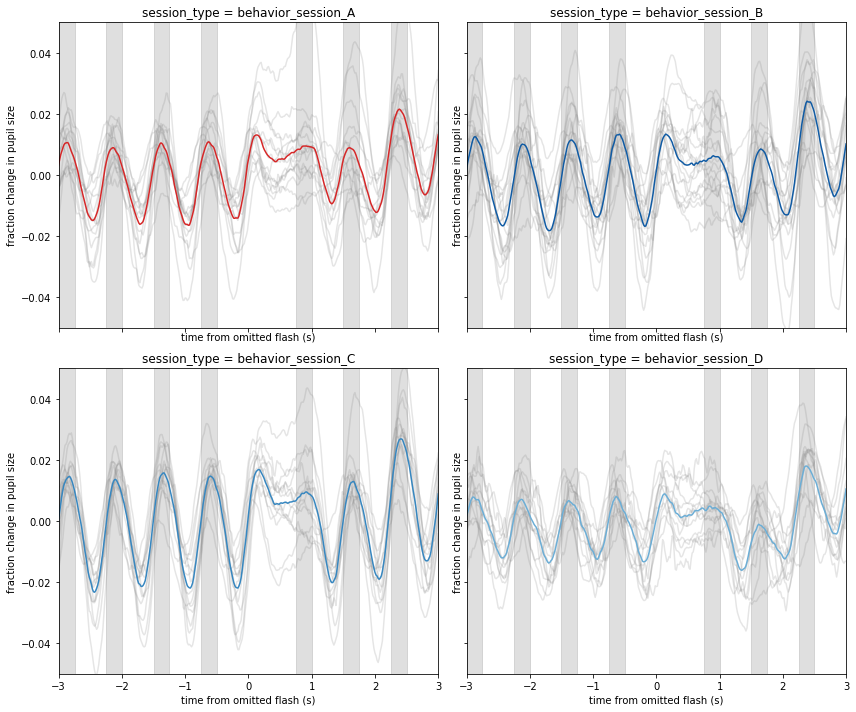

In [11]:
session_types = np.sort(good_sessions.session_type.unique())
colors = get_colors_for_image_sets()

fig,axes=plt.subplots(2,2,figsize=(12,10),sharex=True,sharey=True)

for ii,session_type in enumerate(session_types):
    ax = axes.flatten()[ii]
    
    # get good sessions of this session type
    sessions = good_sessions.query('session_type == @session_type')
    
    # get the column names, excluding 'time', with a session ID matching those in the selected sessions
    cols = [c for c in omitted_response_averages.columns if c != 'time' and int(c) in sessions['ophys_session_id'].unique()]
    
    #plot individual session averages as gray lines
    for col in cols:
        ax.plot(omitted_response_averages['time'],omitted_response_averages[col],color='gray',alpha=0.2)
    
    # plot mean of all session averages
    ax.plot(omitted_response_averages['time'],omitted_response_averages[cols].mean(axis=1),color=colors[ii])
    
    designate_flashes(ax,omit=0,pre_color='gray',post_color='gray')
    ax.set_xlim(-3,3)
    ax.set_xlabel('time from omitted flash (s)')
    ax.set_ylabel('fraction change in pupil size')
    ax.set_ylim(-0.05,0.05)
    ax.set_title('session_type = {}'.format(session_type))
    
fig.tight_layout()

## make one combined plot

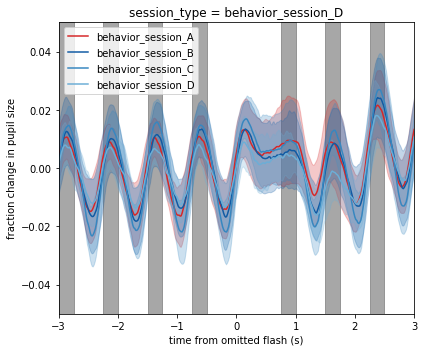

In [12]:
fig,ax=plt.subplots(figsize=(6,5))

for ii,session_type in enumerate(session_types):
    
    # get good sessions of this session type
    sessions = good_sessions.query('session_type == @session_type')
    
    # get the column names, excluding 'time', with a session ID matching those in the selected sessions
    cols = [c for c in omitted_response_averages.columns if c != 'time' and int(c) in sessions['ophys_session_id'].unique()]
    
    # plot standard deviation as span
    ax.fill_between(
        omitted_response_averages['time'],
        omitted_response_averages[cols].mean(axis=1) + omitted_response_averages[cols].std(axis=1),
        omitted_response_averages[cols].mean(axis=1) - omitted_response_averages[cols].std(axis=1),
        color = colors[ii],
        alpha=0.25
    )
    
    # plot mean of all session averages
    ax.plot(omitted_response_averages['time'],omitted_response_averages[cols].mean(axis=1),color=colors[ii])
    
    
    designate_flashes(ax,omit=0,pre_color='gray',post_color='gray')
    ax.set_xlim(-3,3)
    ax.set_xlabel('time from omitted flash (s)')
    ax.set_ylabel('fraction change in pupil size')
    ax.set_ylim(-0.05,0.05)
    ax.set_title('session_type = {}'.format(session_type))
    
ax.legend(session_types,loc='upper left')
fig.tight_layout()

## make one plot per cre line

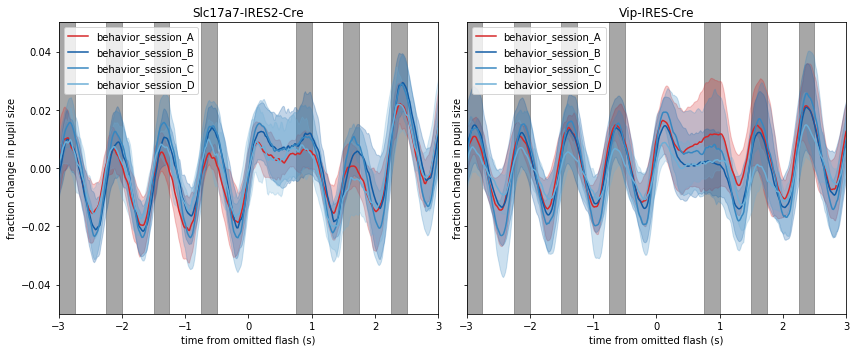

In [13]:
fig,ax=plt.subplots(1,2,figsize=(12,5),sharey=True)

for plot_col, cre_line in enumerate(good_sessions.cre_line.unique()):
    for ii,session_type in enumerate(session_types):

        # get good sessions of this session type
        sessions = good_sessions.query('session_type == @session_type and cre_line == @cre_line')

        # get the column names, excluding 'time', with a session ID matching those in the selected sessions
        cols = [c for c in omitted_response_averages.columns if c != 'time' and int(c) in sessions['ophys_session_id'].unique()]

        # plot standard deviation as span
        ax[plot_col].fill_between(
            omitted_response_averages['time'],
            omitted_response_averages[cols].mean(axis=1) + omitted_response_averages[cols].std(axis=1),
            omitted_response_averages[cols].mean(axis=1) - omitted_response_averages[cols].std(axis=1),
            color = colors[ii],
            alpha=0.25
        )

        # plot mean of all session averages
        ax[plot_col].plot(omitted_response_averages['time'],omitted_response_averages[cols].mean(axis=1),color=colors[ii])


        designate_flashes(ax[plot_col],omit=0,pre_color='gray',post_color='gray')
        ax[plot_col].set_xlim(-3,3)
        ax[plot_col].set_xlabel('time from omitted flash (s)')
        ax[plot_col].set_ylabel('fraction change in pupil size')
        ax[plot_col].set_ylim(-0.05,0.05)
        ax[plot_col].set_title('session_type = {}'.format(session_type))
        ax[plot_col].set_title(cre_line)

    ax[plot_col].legend(session_types,loc='upper left')
    fig.tight_layout()

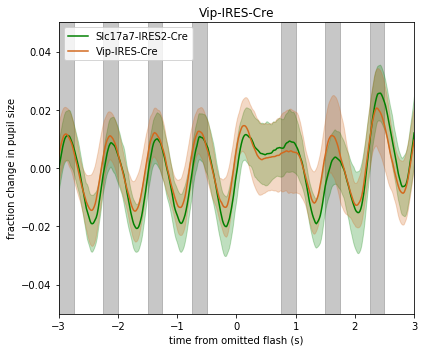

In [19]:
fig,ax=plt.subplots(1,1,figsize=(6,5),sharey=True)

cre_lines = good_sessions.cre_line.unique()
cre_colors = ['green','chocolate']
for ii,cre_line in enumerate(cre_lines):

    # get good sessions of this session type
    sessions = good_sessions.query('cre_line == @cre_line')

    # get the column names, excluding 'time', with a session ID matching those in the selected sessions
    cols = [c for c in omitted_response_averages.columns if c != 'time' and int(c) in sessions['ophys_session_id'].unique()]

    # plot standard deviation as span
    ax.fill_between(
        omitted_response_averages['time'],
        omitted_response_averages[cols].mean(axis=1) + omitted_response_averages[cols].std(axis=1),
        omitted_response_averages[cols].mean(axis=1) - omitted_response_averages[cols].std(axis=1),
        color = cre_colors[ii],
        alpha=0.25
    )

    # plot mean of all session averages
    ax.plot(omitted_response_averages['time'],omitted_response_averages[cols].mean(axis=1),color=cre_colors[ii])


    designate_flashes(ax,omit=0,pre_color='gray',post_color='gray')
    ax.set_xlim(-3,3)
    ax.set_xlabel('time from omitted flash (s)')
    ax.set_ylabel('fraction change in pupil size')
    ax.set_ylim(-0.05,0.05)
    ax.set_title('session_type = {}'.format(session_type))
    ax.set_title(cre_line)

    ax.legend(cre_lines,loc='upper left')
    fig.tight_layout()